# Big Data and Cloud Computing 
## Assignment 2 
-----

#### Group L:
- Diogo Teixeira, 201705082
- João Monteiro, 202108347
- Marta Duarte, 202008344

## Introduction
The increasing adoption of digital health records and monitoring systems in Intensive Care Units (ICUs) has led to the generation of massive volumes of clinical data. Effectively analyzing this data is crucial for gaining insights into patient conditions, supporting real-time medical decisions, and predicting key outcomes such as the length of hospital stay.

In this project, we address the challenge of processing and analyzing the CHARTEVENTS.csv.gz file, a large dataset containing time-stamped clinical events for ICU patients, totaling 4.2 GB in compressed form. Each record corresponds to a specific observation or intervention, associated with a patient (identified by SUBJECT_ID) and, potentially, multiple hospital admissions (HADM_ID).

Our objectives are twofold: (1) perform exploratory data analysis and visualization of patient-specific data, and (2) build a machine learning pipeline capable of predicting the length of ICU stay based on early clinical observations. This involves careful selection of a time window for training data, as using too much data may delay decision-making, while using too little may lead to poor predictive performance.

Given the scale and complexity of the data, we employ advanced tools and techniques such as PySpark, BigQuery, multiprocessing, and traditional ML libraries to ensure efficient processing. We also report execution times and profiling results for each stage of the pipeline, and discuss performance-related challenges encountered along the way.

This report outlines our methodology, design choices, and results, with a focus on the reproducibility and interpretability of the machine learning models developed.

## Libraries

Installation of the necessary libraries

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from xgboost.spark import SparkXGBRegressor


## Bigquery

Create a BigQuery client instance for accessing and querying the dataset. 'bdcc-451416' is the Google Cloud project ID associated with the BigQuery resources.

This client will be used to perform SQL queries on large-scale ICU data stored in the cloud.

In [2]:
client = bigquery.Client(project="bdcc-451416")

This query creates or replaces a BigQuery table that combines ICU stay data with patient demographics. It joins the 'ICUSTAYS' table with the 'PATIENTS' table using SUBJECT_ID, allowing gender and date of birth (DOB) to be added to each ICU record. The patient's age at the time of ICU admission is calculated using DATE_DIFF, and only those with plausible ages between 1 and 100 years are included to exclude likely data entry errors or anonymized outliers. This preprocessing step is critical for ensuring that future models have meaningful and clean features to work with.

In [3]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  icu.*,
  p.GENDER,
  p.DOB,
  DATE_DIFF(DATE(icu.INTIME), DATE(p.DOB), YEAR) AS AGE
FROM
  `bdcc-451416.Dataset1.ICUSTAYS` AS icu
LEFT JOIN
  `bdcc-451416.Dataset1.PATIENTS` AS p
ON
  icu.SUBJECT_ID = p.SUBJECT_ID
WHERE
  DATE_DIFF(DATE(icu.INTIME), DATE(p.DOB), YEAR) BETWEEN 1 AND 100
"""

# Run the query and store results
client.query(query).result()

print(f"Took {time() - start} seconds")

Took 3.245033025741577 seconds


To further enrich the existing ICU dataset, this step joins it with relevant information from the ADMISSIONS table. The goal is to add contextual features related to the hospital admission—such as admission type (e.g., emergency or elective), location, insurance type, ethnicity, religion, and marital status—which are often significant predictors in healthcare-related models. The join uses both SUBJECT_ID and HADM_ID for precise matching per admission episode. The result is written back to the same BigQuery table using CREATE OR REPLACE to maintain pipeline continuity without generating redundant tables.

In [4]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  af.*,
  a.ADMISSION_TYPE,
  a.ADMISSION_LOCATION,
  a.INSURANCE,
  a.ETHNICITY,
  a.RELIGION,
  a.MARITAL_STATUS
FROM `bdcc-451416.Dataset1.Dataset` AS af
LEFT JOIN (
  SELECT
    SUBJECT_ID,
    HADM_ID,
    ADMISSION_TYPE,
    ADMISSION_LOCATION,
    INSURANCE,
    ETHNICITY,
    RELIGION,
    MARITAL_STATUS
  FROM `bdcc-451416.Dataset1.ADMISSIONS`
) AS a
ON af.SUBJECT_ID = a.SUBJECT_ID AND af.HADM_ID = a.HADM_ID
"""

client.query(query).result()

print(f"Took {time() - start} seconds")

Took 2.3905649185180664 seconds


In this stage, the dataset is augmented with a new feature: the number of diagnoses associated with each hospital admission (HADM_ID). This is achieved by joining the main dataset with an aggregated subquery on the DIAGNOSES_ICD table, which counts the diagnostic codes per admission. This count serves as a proxy for patient complexity or illness severity. A LEFT JOIN ensures all records from the main dataset are retained—even when no diagnoses exist (in which case the count is NULL and converted to 0 using IFNULL). The enriched dataset is then written back to the same table to maintain a clean, linear transformation pipeline.

In [5]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  d.*,
  IFNULL(dx.NUM_DIAGNOSES, 0) AS NUM_DIAGNOSES
FROM `bdcc-451416.Dataset1.Dataset` AS d
LEFT JOIN (
  SELECT
    HADM_ID,
    COUNT(*) AS NUM_DIAGNOSES
  FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
  GROUP BY HADM_ID
) AS dx
ON d.HADM_ID = dx.HADM_ID
"""

client.query(query).result()

print(f"Took {time() - start} seconds")


Took 2.0224592685699463 seconds


## Feature Engineering

To transform diagnosis codes into model-friendly features, this step identifies the 100 most frequent ICD9 diagnosis codes and converts them into binary (one-hot) columns. A SQL query first retrieves the top codes from the DIAGNOSES_ICD table, and the data is then pivoted so that each code becomes a separate column indicating its presence (1) or absence (0) for each hospital admission (HADM_ID). Column names are cleaned to ensure BigQuery compatibility. These features are added to the dataset via a left join, creating a structured input for downstream machine learning models.

In [6]:
start = time()

# Get top 100 ICD9 codes from BigQuery
top_codes_query = """
SELECT ICD9_CODE
FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
GROUP BY ICD9_CODE
ORDER BY COUNT(*) DESC
LIMIT 100
"""

top_codes_df = client.query(top_codes_query).to_dataframe()
top_codes = top_codes_df["ICD9_CODE"].tolist()

# Sanitize column names: replace '.' with '_', prefix with ICD9_
code_map = {code: f"{code.replace('.', '_')}" for code in top_codes}

# Format for BigQuery pivot IN clause and SELECT
pivot_in_clause = ", ".join(f"'{code}'" for code in top_codes)
select_clause = ",\n  ".join(
    f"IFNULL(p.`{code}`, 0) AS `{alias}`"
    for code, alias in code_map.items()
)

# Construct final SQL
pivot_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
WITH filtered AS (
  SELECT HADM_ID, ICD9_CODE
  FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
  WHERE ICD9_CODE IN ({pivot_in_clause})
),
onehot AS (
  SELECT HADM_ID, ICD9_CODE, 1 AS present FROM filtered
),
pivoted AS (
  SELECT * FROM onehot
  PIVOT (
    MAX(present) FOR ICD9_CODE IN ({pivot_in_clause})
  )
)
SELECT
  d.*,
  {select_clause}
FROM `bdcc-451416.Dataset1.Dataset` d
LEFT JOIN pivoted p
ON d.HADM_ID = p.HADM_ID
"""

# Run the query
client.query(pivot_query).result()

print(f"Took {time() - start} seconds")


Took 6.53154444694519 seconds


Advanced feature engineering is performed here by extracting time-windowed summary statistics from the CHARTEVENTS table, which logs high-frequency ICU measurements. The process starts by selecting the 100 most frequent ITEMIDs. For each ICU stay (ICUSTAY_ID), only events from the first 24 hours are retained. Measurements are min-max scaled by their unit (VALUEUOM), and for each ITEMID, the mean, min, max, and standard deviation are calculated. These are then pivoted into wide format (e.g., ITEM_220045_MEAN), and the resulting features are joined to the main dataset, enriching it with normalized physiological trends.

In [7]:
start = time()

top_items_query = """
SELECT ITEMID
FROM `bdcc-451416.Dataset1.CHAREVENTS`
GROUP BY ITEMID
ORDER BY COUNT(*) DESC
LIMIT 100
"""
top_items = client.query(top_items_query).to_dataframe()["ITEMID"].tolist()

# Generate pivot clause and final SELECT fields
pivot_clause = ", ".join([f"'{item}'" for item in top_items])
agg_stats = ['MEAN', 'MIN', 'MAX', 'STD']
select_exprs = [
    f"IFNULL(p.`{item}_{stat}`, 0) AS `ITEM_{item}_{stat}`"
    for item in top_items for stat in agg_stats
]
select_clause = ",\n  ".join(select_exprs)

# Step 2: PIVOT + AGGREGATE query (write to intermediate table)
pivot_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.pivoted_chartevents_24h` AS
WITH chart_with_intime AS (
  SELECT
    ce.ICUSTAY_ID,
    ce.ITEMID,
    ce.VALUENUM,
    ce.VALUEUOM,
    d.INTIME,
    TIMESTAMP_DIFF(ce.CHARTTIME, d.INTIME, SECOND)/3600.0 AS HOURS
  FROM `bdcc-451416.Dataset1.CHAREVENTS` ce
  JOIN `bdcc-451416.Dataset1.Dataset` d
    ON ce.ICUSTAY_ID = d.ICUSTAY_ID
),
filtered AS (
  SELECT *
  FROM chart_with_intime
  WHERE HOURS BETWEEN 0 AND 24
    AND VALUENUM IS NOT NULL
    AND VALUEUOM IS NOT NULL
),
stats AS (
  SELECT VALUEUOM, MIN(VALUENUM) AS MIN_VAL, MAX(VALUENUM) AS MAX_VAL
  FROM filtered
  GROUP BY VALUEUOM
),
scaled AS (
  SELECT
    f.ICUSTAY_ID,
    f.ITEMID,
    (f.VALUENUM - s.MIN_VAL) / NULLIF((s.MAX_VAL - s.MIN_VAL), 0) AS SCALED_VALUENUM
  FROM filtered f
  JOIN stats s ON f.VALUEUOM = s.VALUEUOM
),
aggregated AS (
  SELECT
    ICUSTAY_ID,
    ITEMID,
    AVG(SCALED_VALUENUM) AS MEAN,
    MIN(SCALED_VALUENUM) AS MIN,
    MAX(SCALED_VALUENUM) AS MAX,
    STDDEV_SAMP(SCALED_VALUENUM) AS STD
  FROM scaled
  GROUP BY ICUSTAY_ID, ITEMID
),
pivot_input AS (
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MEAN') AS metric, MEAN AS value FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MIN'), MIN FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MAX'), MAX FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_STD'), STD FROM aggregated
),
pivoted AS (
  SELECT * FROM pivot_input
  PIVOT (
    MAX(value) FOR metric IN ({', '.join(f"'{item}_{stat}'" for item in top_items for stat in agg_stats)})
  )
)
SELECT * FROM pivoted
"""

# Run the first query to create pivoted table
client.query(pivot_query).result()

# Step 3: Final join to dataset
join_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset_With_Chartevents` AS
SELECT
  d.*,
  {select_clause}
FROM `bdcc-451416.Dataset1.Dataset` d
LEFT JOIN `bdcc-451416.Dataset1.pivoted_chartevents_24h` p
ON d.ICUSTAY_ID = p.ICUSTAY_ID
"""

# Run the join query
client.query(join_query).result()

print(f"Took {time() - start} seconds")


Took 12.164590835571289 seconds


To capture monitoring intensity during ICU stays, this feature engineering step calculates the event frequency per hour for the 10 most common ITEMIDs in CHARTEVENTS. After identifying the top ITEMIDs, it computes ICU stay duration (capped at 14 days) and counts each item’s occurrences. The average event rate per hour is derived by dividing counts by duration. These values are pivoted into separate columns (e.g., hourly_events211), with missing values filled as 0. The result is merged back into the main dataset to complete this layer of feature enrichment.

In [8]:
start = time()

query_itemids = f"""
SELECT ITEMID
FROM `bdcc-451416.Dataset1.CHAREVENTS`
GROUP BY ITEMID
ORDER BY COUNT(*) DESC
LIMIT 100
"""

itemids = [
    int(row["ITEMID"]) for row in client.query(query_itemids).result()
    if row["ITEMID"] is not None and str(row["ITEMID"]).strip() != ""
]
pivot_columns = ", ".join([f"{itemid}" for itemid in itemids])

null_safe_columns = ",\n  ".join(
        [f"IFNULL(SAFE_CAST(ep.`_{itemid}` AS FLOAT64), 0) AS hourly_events{itemid}" for itemid in itemids]
)

full_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset_Final` AS

WITH chart_with_intime AS (
  SELECT
    ce.ICUSTAY_ID,
    d.INTIME,
    TIMESTAMP_DIFF(ce.CHARTTIME, d.INTIME, SECOND)/3600.0 AS HOURS
  FROM `bdcc-451416.Dataset1.CHAREVENTS` ce
  JOIN `bdcc-451416.Dataset1.Dataset` d
    ON ce.ICUSTAY_ID = d.ICUSTAY_ID
),

-- 1. Duration per patient
patient_duration AS (
  SELECT
    ICUSTAY_ID,
    MAX(HOURS) AS DURATION_HOURS
  FROM chart_with_intime
  GROUP BY ICUSTAY_ID
  HAVING MAX(HOURS) BETWEEN 1 AND 336
),

-- 2. Events per item
events_per_item AS (
  SELECT
    ICUSTAY_ID,
    ITEMID,
    COUNT(*) AS NUM_EVENTOS
  FROM `bdcc-451416.Dataset1.CHAREVENTS`
  GROUP BY ICUSTAY_ID, ITEMID
),

-- 3. Join with duration and compute events per hour
events_with_tax AS (
  SELECT
    epi.ICUSTAY_ID,
    epi.ITEMID,
    SAFE_DIVIDE(epi.NUM_EVENTOS, dp.DURATION_HOURS) AS HOURLY_EVENTS
  FROM events_per_item epi
  LEFT JOIN patient_duration dp USING(ICUSTAY_ID)
--   WHERE epi.ITEMID IN ({pivot_columns})
),

-- 4. Pivot
events_pivot AS (
  SELECT *
  FROM (
    SELECT ICUSTAY_ID, ITEMID, HOURLY_EVENTS
    FROM events_with_tax
  )
  PIVOT (
    MAX(HOURLY_EVENTS) FOR ITEMID IN ({pivot_columns})
  )
)

-- 5. Merge with base dataset and replace NULLs
SELECT
  d.*,
  {null_safe_columns}
FROM `bdcc-451416.Dataset1.Dataset_With_Chartevents` d
LEFT JOIN events_pivot ep
ON d.ICUSTAY_ID = ep.ICUSTAY_ID
"""

client.query(full_query).result()

print(f"Took {time() - start} seconds")


Took 8.211430311203003 seconds


## Modeling: Length of Stay (LOS) Regression using Spark

Initialize a Spark session configured to connect with BigQuery using the appropriate connector. This session will be used to build and train a regression model for predicting Length of Stay (LOS). The 'spark-bigquery-with-dependencies_2.12:0.36.0' package is required to seamlessly read from and write to BigQuery tables, and is resolved via Maven using Ivy (locally cached if previously downloaded). This step marks the start of the modeling phase, where Spark provides the distributed computing power necessary for scalable machine learning.

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from xgboost.spark import SparkXGBRegressor

from time import time

import numpy as np

import matplotlib.pyplot as plt


In [10]:
spark = SparkSession.builder \
    .appName("LOS Regression") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.0") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")



25/06/07 18:22:28 WARN Utils: Your hostname, joaomonteiro resolves to a loopback address: 127.0.1.1; using 192.168.1.243 instead (on interface wlo1)
25/06/07 18:22:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/joaomonteiro/.ivy2/cache
The jars for the packages stored in: /home/joaomonteiro/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0c40f44d-bfb8-412c-acb8-4b61a8be74ba;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/joaomonteiro/Desktop/BDCC/env_bdcc/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.0 in central
:: resolution report :: resolve 102ms :: artifacts dl 3ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-0c40f44d-bfb8-412c-acb8-4b61a8be74ba
	confs: [default]
	0 artifacts copied, 1 already retrieved (0kB/4ms)
25/06/07 18:22:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting defa

This phase executes the full preprocessing pipeline required to train a regression model for predicting Length of Stay (LOS). It begins by loading the finalized dataset from BigQuery and filtering out records with invalid or missing LOS values. Categorical features are string-indexed and one-hot encoded, while numeric features are preserved. All features are assembled into a single vector using Spark's VectorAssembler, producing a clean DataFrame with 'features' and the target 'LOS' column, ready for modeling.

In [11]:
start = time()

df = spark.read.format("bigquery") \
    .option("project", "bdcc-451416") \
    .option("dataset", "Dataset1") \
    .option("table", "Dataset_Final") \
    .load()

df_clean = df.filter((col("LOS").isNotNull()) & (col("LOS") >= 0))


excluded = {'ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID',
            'LAST_CAREUNIT', 'LAST_WARDID', 'INTIME', 'OUTTIME', 'DOB', 'LOS'}

feature_cols = [c for c in df_clean.columns if c not in excluded]




categorical_cols = ["DBSOURCE", "FIRST_CAREUNIT", "FIRST_WARDID", "GENDER",
                    "ADMISSION_TYPE", "ADMISSION_LOCATION", "INSURANCE", "ETHNICITY",
                    "RELIGION", "MARITAL_STATUS"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in categorical_cols
]

encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols]
)


excluded = set(categorical_cols + ["LOS", "ICUSTAY_ID"])
numeric_features = [c for c in df_clean.columns if c not in excluded and df_clean.schema[c].dataType.simpleString() in ['double', 'int']]

# One-hot encoded feature columns
encoded_features = [f"{col}_ohe" for col in categorical_cols]

# Full feature list for VectorAssembler
all_features = numeric_features + encoded_features


assembler = VectorAssembler(inputCols=all_features, outputCol="features")

pipeline = Pipeline(stages=indexers + [encoder, assembler])
df_transformed = pipeline.fit(df_clean).transform(df_clean)

# Now select features and label
df_final = df_transformed.select("features", "LOS")

df_final = df_final.filter(df_final["LOS"] > 1)

print(f"Took {time() - start} seconds")


Took 13.295500040054321 seconds


Feature scaling is applied next using Spark’s StandardScaler. Scaling standardizes the 'features' vector to have zero mean and unit variance—an important step for many ML algorithms, especially those based on distances or linearity assumptions. The output is stored in a new column named scaled_features, which becomes the model’s input for training.

In [12]:
start = time()

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_final)
df_scaled = scaler_model.transform(df_final)

print(f"Took {time() - start} seconds")


Took 17.67584252357483 seconds


Dimensionality reduction is achieved via Principal Component Analysis (PCA). This step compresses the high-dimensional scaled_features vector into 200 principal components, retaining as much variance as possible. The resulting pca_features column replaces the original input and helps reduce noise, address multicollinearity, and potentially improve model performance by focusing on the most informative features.

In [13]:
start = time()

# Define PCA transformer (reduce to k principal components)
pca = PCA(k=200, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)

# Transform the data
df_pca = pca_model.transform(df_scaled).select("pca_features", "LOS")

print(f"Took {time() - start} seconds")


Took 44.853618144989014 seconds


## Model training, Evaluation and Visualization

To prepare for model evaluation, the dataset is split into training and testing subsets using a 70/30 ratio, with a fixed random seed for reproducibility. The training data is used to fit the regression model, while the test data is held back for validating generalization performance on unseen examples.

In [14]:
def evaluate_model(predictions, ):
    start = time()
    evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

    mae  = evaluator.setMetricName("mae").evaluate(predictions)
    mse  = evaluator.setMetricName("mse").evaluate(predictions)
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    r2   = evaluator.setMetricName("r2").evaluate(predictions)
    print(f"Evaluation took {time() - start} seconds")



    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

def plot_preds(predictions):

    start = time()
    results = predictions.select("LOS", "prediction") \
        .sample(withReplacement=False, fraction=0.01, seed=42) \
        .orderBy("LOS", ascending=False) \
        .toPandas()

    y_test_sorted = results["LOS"].values
    y_pred_sorted = results["prediction"].values
    residuals = y_test_sorted - y_pred_sorted

    plt.figure(figsize=(8, 3))
    plt.plot(y_test_sorted, label='Actual LOS')
    plt.plot(y_pred_sorted, label='Predicted LOS')
    plt.title('Actual vs Predicted LOS (sorted by Actual LOS - descending)')
    plt.xlabel('Sample index (sorted)')
    plt.ylabel('Length of Stay (LOS)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.bar(range(len(residuals)), residuals, color='orange')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Residuals (Actual LOS − Predicted LOS)')
    plt.xlabel('Sample index (sorted by Actual LOS)')
    plt.ylabel('Residual (error)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Plotting took {time() - start} seconds")


def train_model(model, param_grid, evaluator, num_folds=5, parallelism=1):

    cv = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=num_folds,
        parallelism=parallelism
    )

    cv_model = cv.fit(train_df)


    return cv_model



In [15]:
train_df, test_df = df_pca.randomSplit([0.7, 0.3], seed=42)

We define an XGBoost regressor using the Spark integration for distributed training. The model uses the PCA-reduced features as input and aims to predict the Length of Stay (LOS). Verbosity is set to 0 to reduce console output during training.

We define a grid of hyperparameters for tuning the XGBoost model. Specifically, we vary the maximum tree depth and learning rate. This grid will be used during cross-validation to find the best-performing configuration.

Finally, we define an evaluator for regression tasks using Root Mean Squared Error (RMSE) as the evaluation metric.



In [ ]:
xgb = SparkXGBRegressor(
    label_col="LOS",
    features_col="pca_features",
    prediction_col="prediction",
    verbosity=0
)


paramGrid = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [4, 6]) \
    .addGrid(xgb.learning_rate, [0.1, 0.3]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol="LOS",
    predictionCol="prediction",
    metricName="rmse"
)


We iterate through different levels of parallelism (1 to 6 threads) to benchmark training time. For each setting, the training time is recorded and printed. This helps evaluate how parallelism impacts performance in a distributed environment.


In [17]:
xgb_training_times = []

for i in range(1, 7):

    print(f"Training with {i} threads\n")
    start = time()

    xgb_model = train_model(xgb, paramGrid, evaluator, parallelism=i)

    print(f"Training with {i} threads took {time() - start} seconds")

    xgb_training_times.append(time() - start)


Training with 1 threads



2025-06-07 18:24:04,187 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:24:07,253 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[18:24:08] Task 0 got rank 0
[18:24:08] [0]	training-rmse:6.22282
[18:24:09] [1]	training-rmse:5.89029
[18:24:09] [2]	training-rmse:5.60414
[18:24:09] [3]	training-rmse:5.36045
[18:24:09] [4]	training-rmse:5.15103
[18:24:09] [5]	training-rmse:4.97451
[18:24:09] [6]	training-rmse:4.82352
[18:24:09] [7]	training-rmse:4.69741
[18:24:09] [8]	training-rmse:4.58413
[18:24:09] [9]	training-rmse:4.48851
[18:24:09] [10]	training-rmse:4.39731
[18:24:09] [11]	training-rmse:4.32148
[18:24:09] [12]	training-rmse:4.25875
[18:24:09] [13]	training-rmse:4.20587
[18:24:09] [14]	tra

Training with 1 threads took 317.4082055091858 seconds
Training with 2 threads



2025-06-07 18:29:17,654 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:29:17,656 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:29:19,045 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
2025-06-07 18:29:19,045 INFO XGBoost-PySpark: _train_booster Training on CPUs
[18:29:20] Task 0 got rank 0[18:29:20] Task 0 got rank 0

[18:29:20] [0]	training-rmse:5.51094
[18:29:20] [0]	training-rmse:6.22282
[18:29:20] 

Training with 2 threads took 233.25745058059692 seconds
Training with 3 threads



2025-06-07 18:33:11,671 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:33:11,681 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:33:11,686 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	

Training with 3 threads took 227.49086499214172 seconds
Training with 4 threads



2025-06-07 18:36:59,505 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:36:59,511 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:36:59,525 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	

Training with 4 threads took 187.1391201019287 seconds
Training with 5 threads



2025-06-07 18:40:05,886 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:40:05,899 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:40:05,904 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	

Training with 5 threads took 186.16185474395752 seconds
Training with 6 threads



2025-06-07 18:43:11,879 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:43:11,885 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 6, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-07 18:43:11,904 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	

Training with 6 threads took 184.0100874900818 seconds


The training times clearly show a significant improvement in performance as the number of threads increases from 1 to 6. With a single thread, the training took approximately 317 seconds, while increasing the thread count to 6 reduced the time to around 184 seconds.

We observe diminishing returns beyond 4 threads: the most substantial time reduction occurs when moving from 1 to 4 threads, dropping from 317 seconds to about 187 seconds. After that, increasing threads to 5 and 6 yields only marginal improvements, around 1-3 seconds faster.

This behavior is expected due to factors such as overhead from thread management, possible contention for shared resources (CPU, memory, I/O), and the inherent parallelizability of the training task. It indicates that using 4 to 6 threads optimizes the trade-off between parallelism gains and overhead in this particular setup.

Overall, parallel training significantly accelerates the model fitting, making it much more efficient.

In [18]:
xgb_predictions = xgb_model.transform(test_df)

xgb_results = evaluate_model(xgb_predictions)



2025-06-07 18:46:03,660 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-06-07 18:46:17,434 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-06-07 18:46:29,464 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-06-07 18:46:42,013 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Evaluation took 51.154847621917725 seconds
MAE: 2.03
MSE: 16.87
RMSE: 4.11
R²: 0.64


The evaluation of the XGBoost model on the test set took approximately 51 seconds, which is reasonable given the dataset size and model complexity.

The prediction errors are summarized as follows:

Mean Absolute Error (MAE) of 2.03 indicates that, on average, the model's predicted length of stay deviates from the actual value by about 2 days.

Mean Squared Error (MSE) of 16.87 and Root Mean Squared Error (RMSE) of 4.11 show that there are some larger errors present, but overall the predictions are fairly accurate.

The coefficient of determination (R²) is 0.64, meaning the model explains 64% of the variance in length of stay, which is a good indication of predictive power for this complex problem.

In summary, the model provides reasonably accurate predictions with moderate error, showing good explanatory capability, but there is still room for improvement, possibly by feature engineering or exploring other model architectures.

Now, we do an analysis for a Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    labelCol="LOS",
    featuresCol="pca_features", 
    predictionCol="prediction"
)

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol="LOS",
    predictionCol="prediction",
    metricName="rmse"
)


In [20]:
lr_training_times = []

for i in range(1, 7):

    print(f"Training with {i} threads\n")
    start = time()

    lr_model = train_model(lr, lr_param_grid, evaluator, parallelism=i)

    print(f"Training with {i} threads took {time() - start} seconds")

    lr_training_times.append(time() - start)




Training with 1 threads



Training with 1 threads took 169.61600184440613 seconds
Training with 2 threads



Training with 2 threads took 159.0614047050476 seconds
Training with 3 threads



Training with 3 threads took 159.99734830856323 seconds
Training with 4 threads



Training with 4 threads took 158.97568082809448 seconds
Training with 5 threads



Training with 5 threads took 153.31613087654114 seconds
Training with 6 threads



Training with 6 threads took 164.06008625030518 seconds


The training times for the linear regression model show relatively minor improvements with increasing thread counts. For example, training with 3 threads took approximately 160 seconds, while using 5 threads reduced it slightly to about 153 seconds. However, increasing to 6 threads unexpectedly increased the training time to 164 seconds.

This suggests that linear regression, being a relatively simple and fast model compared to more complex ones like XGBoost, does not benefit significantly from increased parallelism , and fewer threads may be more efficient.

In [21]:
lr_predictions = lr_model.transform(test_df)

lr_results = evaluate_model(lr_predictions)


Evaluation took 52.743651390075684 seconds
MAE: 2.79
MSE: 22.82
RMSE: 4.78
R²: 0.52


The evaluation of the linear regression model took approximately 52.7 seconds (comparable to the evaluation time for XGBoost), likely due to the size of the test set and not the model complexity.

The performance metrics are as follows:

MAE: 2.79 – on average, predictions deviate from the actual length of stay by nearly 2.8 days, which is notably higher than the MAE from the XGBoost model (2.03).

MSE: 22.82 and RMSE: 4.78 – both error measures are also worse than XGBoost’s, indicating less accurate predictions and a higher presence of large errors.

R²: 0.52 – the model explains only 52% of the variance in the length of stay, which is 12 percentage points lower than XGBoost (0.64).

Overall, while linear regression is much simpler and faster to train, it underperforms significantly compared to XGBoost in terms of predictive accuracy. These results suggest that linear models may be too limited for capturing the complex relationships in ICU data.

In the next step, a small random sample (1%) of the predictions is taken from both the XGBoost and Linear Regression models using the same random seed to ensure consistency. The LOS (true label) is retained, and the prediction column is renamed to distinguish between models. 

In [22]:
sample_fraction = 0.01
seed = 42

xgb_sample = xgb_predictions.select("LOS", "prediction") \
    .withColumnRenamed("prediction", "xgb_pred") \
    .sample(False, sample_fraction, seed)

lr_sample = lr_predictions.select("LOS", "prediction") \
    .withColumnRenamed("prediction", "lr_pred") \
    .sample(False, sample_fraction, seed)

In [23]:
combined = xgb_sample.join(lr_sample, on="LOS")
combined_pd = combined.orderBy("LOS", ascending=False).toPandas()


2025-06-07 19:03:55,046 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Now, we plot to compare the true LOS against predictions from both models. It visually shows how closely each model tracks the actual values. XGBoost predictions are consistently closer to the ground truth, especially for patients with longer stays (which suggests that the model is better at capturing non-linear patterns and handling more complex relationships in the data), confirming its superior accuracy. Linear Regression tends to underestimate high LOS values and shows more erratic behavior across the range. This is expected from a linear model, which lacks the capacity to adapt to the non-linear and potentially skewed distribution of LOS in ICU patients.

The second plot displays residuals (errors) for each model. A positive residual means the model underestimated the LOS, while a negative residual means it overestimated. XGBoost's residuals appear smaller and more balanced around zero, indicating better overall accuracy whereas Linear Regression shows larger and more variable errors. 


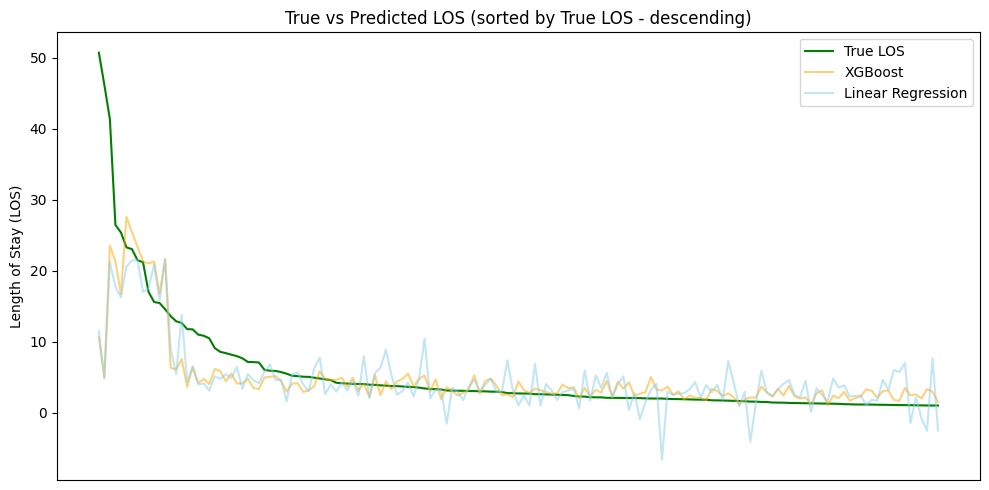

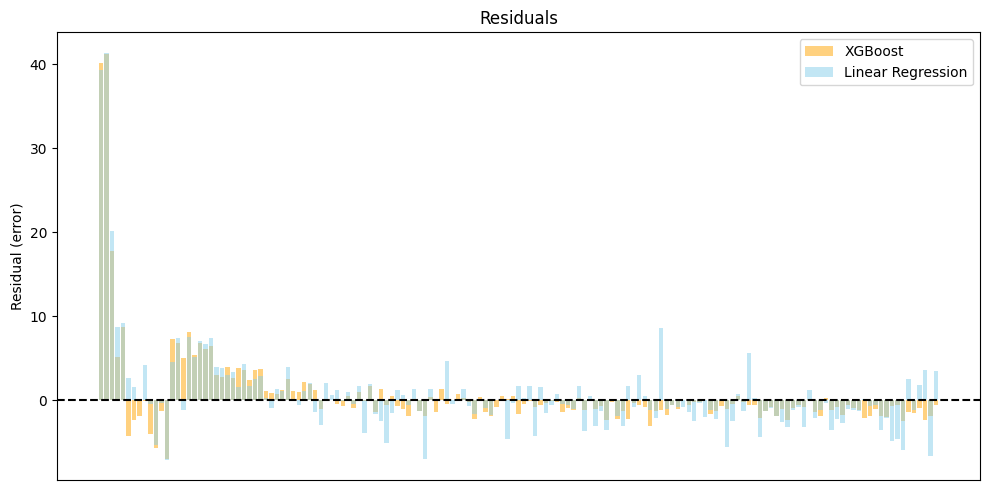

In [24]:
y_true = combined_pd["LOS"].values
y_xgb  = combined_pd["xgb_pred"].values
y_lr   = combined_pd["lr_pred"].values


xgb_residuals = y_true - y_xgb
lr_residuals = y_true - y_lr

plt.figure(figsize=(10, 5))

plt.plot(y_true, label="True LOS", linestyle="-", color="green")
plt.plot(y_xgb, label="XGBoost", linestyle="-", alpha=0.5, color="orange")
plt.plot(y_lr, label="Linear Regression", linestyle="-", alpha=0.5, color="skyblue")

plt.title('True vs Predicted LOS (sorted by True LOS - descending)')
plt.ylabel('Length of Stay (LOS)')

plt.xticks([])

plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(range(len(xgb_residuals)), xgb_residuals, alpha=0.5, label='XGBoost', color="orange")
plt.bar(range(len(lr_residuals)), lr_residuals, alpha=0.5, label='Linear Regression', color="skyblue")
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals')
plt.ylabel('Residual (error)')

plt.xticks([])

plt.legend()
plt.tight_layout()
plt.show()

This visualization further supports the conclusion that XGBoost yields more accurate and stable predictions.

Now, we aggregate and present the evaluation metrics (e.g., MAE, MSE, RMSE, R²).

In [42]:
results_df = pd.DataFrame({
    'XGBoost': xgb_results,
    'Linear Regression': lr_results
}).T

display(results_df)

,mae,mse,rmse,r2
XGBoost,2.030509,16.874451,4.107852,0.643118
Linear Regression,2.786872,22.821570,4.777193,0.517340


XGBoost clearly outperforms Linear Regression across all metrics. It achieves: (1) Lower MAE and RMSE, meaning more accurate predictions on average and less severe errors; (2) Higher R² (0.64 vs 0.52), indicating a better overall fit and stronger explanatory power of the model.

In the plot below we present the tiem taken to train the model with the different models across different number of threads.

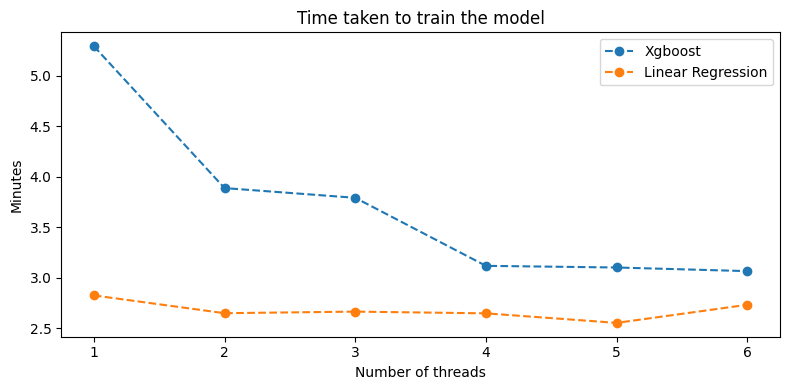

In [25]:
x_values = list(range(1, 7))

plt.figure(figsize=(8, 4))
plt.plot(x_values, np.array(xgb_training_times)/60, marker='o', linestyle='--', label="Xgboost")
plt.plot(x_values, np.array(lr_training_times)/60, marker='o', linestyle='--', label="Linear Regression")
plt.title("Time taken to train the model")
plt.xlabel("Number of threads")
plt.ylabel("Minutes")
plt.legend()
plt.tight_layout()
plt.show()

Increasing the number of threads allows Spark’s CrossValidator to parallelize hyperparameter tuning and cross-validation folds, leading to reduced training times—up to a point.

For complex models like XGBoost, increasing the number of threads in CrossValidator provides substantial speedup, especially in the lower range (1–4 threads). For simpler models like Linear Regression, parallelism has limited impact, and performance gains are small.


## XGBOOST

In [ ]:
from IPython.display import Image
from IPython.display import display

To understand how parallelism influences resource usage, we observed CPU core activity during model training under different thread configurations. First we do to XGBoost.

XGBoost:
1 Thread:


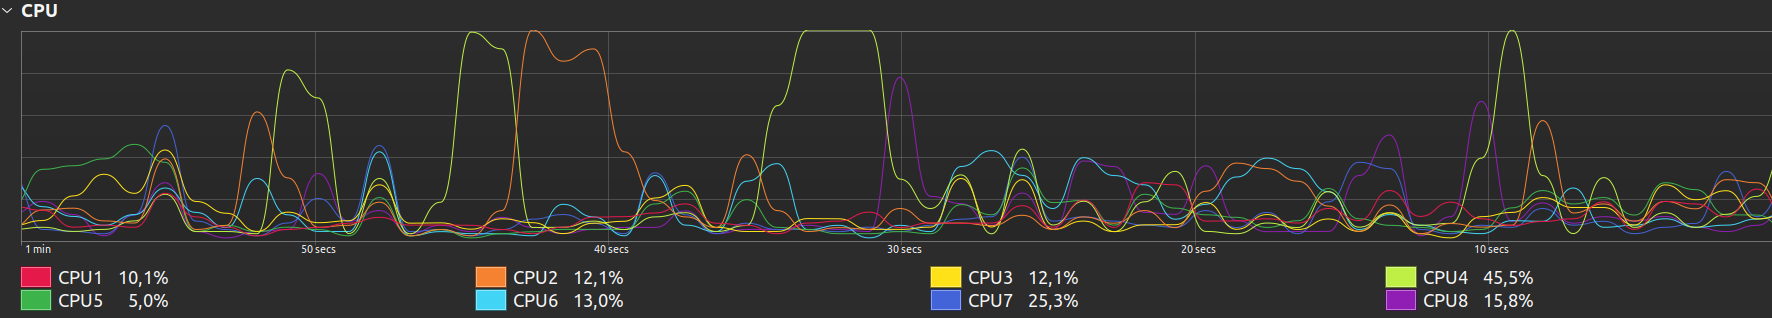

3 Threads:


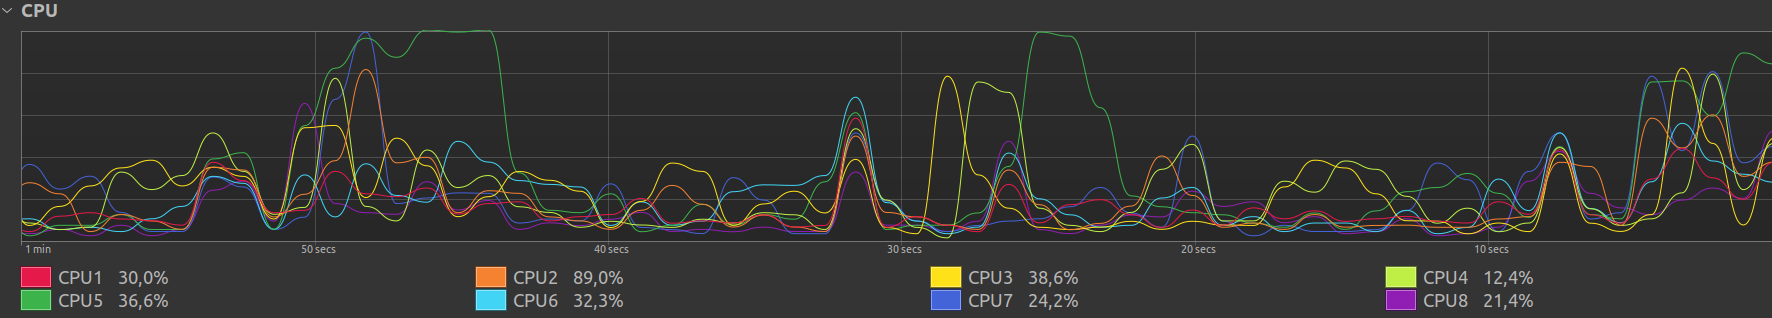

6 Threads:


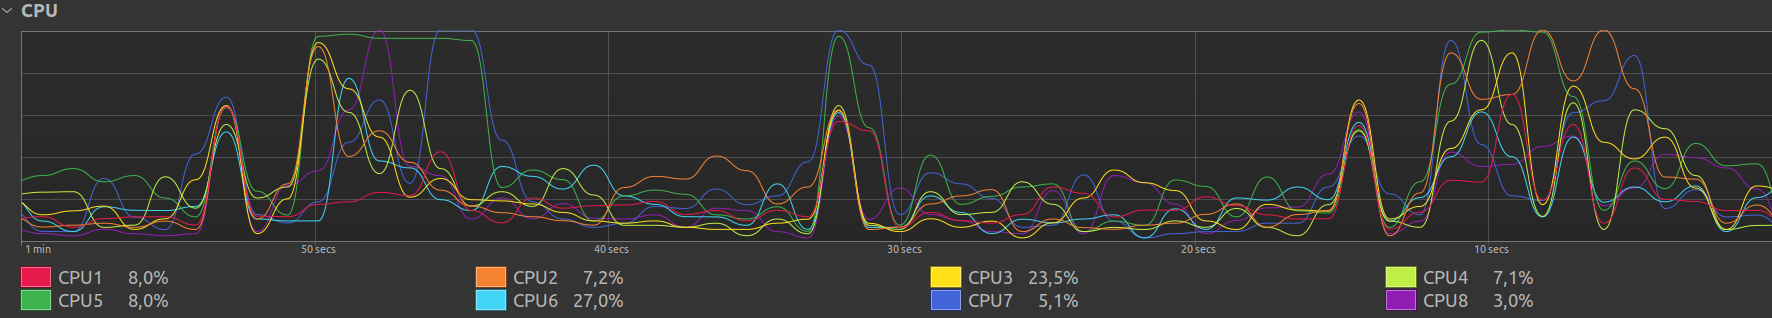

In [31]:
print("1 Thread:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/xgb_1_thread.png', embed=True))

print("3 Threads:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/xgb_3_threads.png', embed=True))

print("6 Threads:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/xgb_6_threads.png', embed=True))


First image (1 thread): Only a single core is visibly active during training, indicating that the workload is not parallelized.

Second image (3 threads): Approximately three cores appear to be utilized concurrently, suggesting that the Spark CrossValidator is distributing tasks across threads.

Last image (6 threads): Up to six cores seem to be active, reflecting increased parallel execution as the number of threads grows.

It's important to note that these observations are not precise benchmarks, as the system was also running other processes (e.g., the Python environment and background services), which may influence core activity. However, the general pattern is clear: increasing the number of threads in the CrossValidator corresponds to higher CPU core utilization during model training.

This aligns with expectations: more threads enable concurrent execution of hyperparameter tuning tasks or cross-validation folds, leading to better resource utilization though actual performance gains may plateau due to overhead or other bottlenecks.


## Logistic Regression

This time we do the same to the Logistic Regression.

1 Thread:


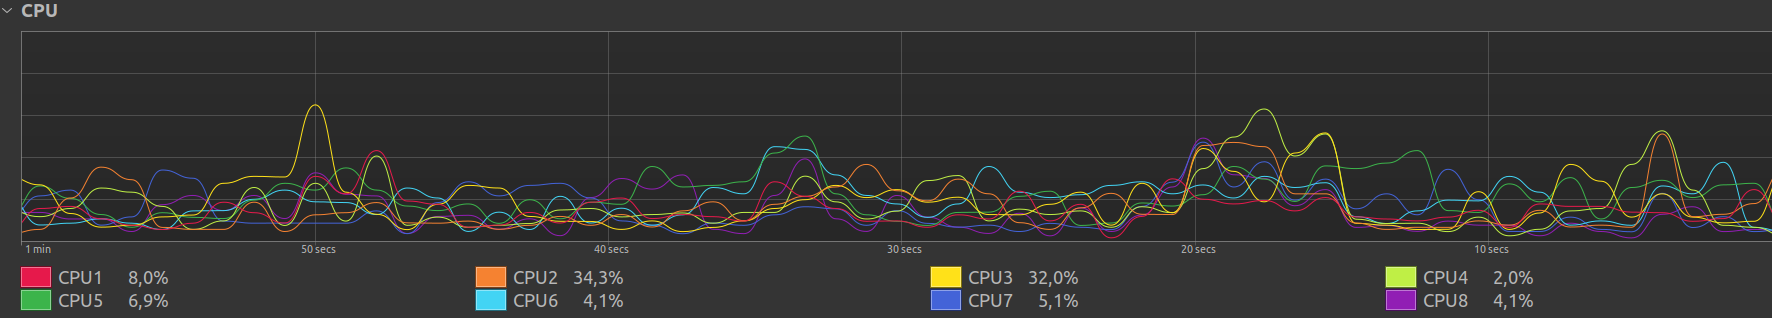

3 Threads:


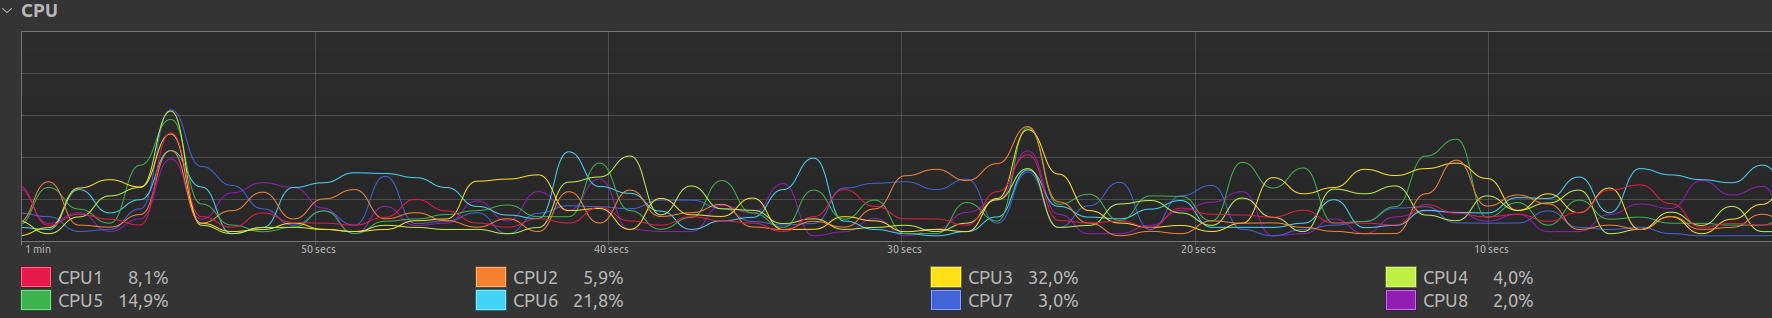

6 Threads:


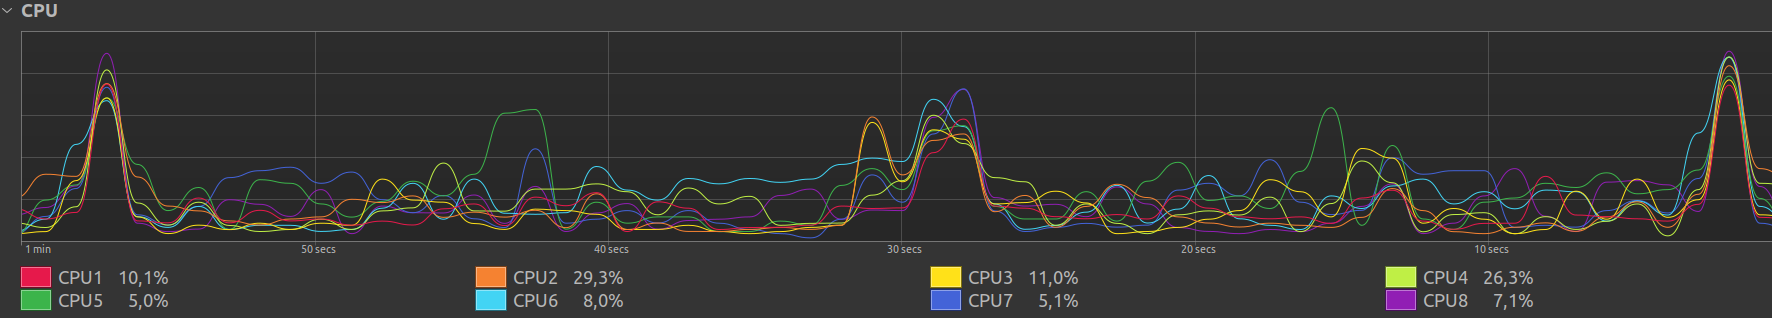

In [35]:
print("1 Thread:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/lr_1_thread.png', embed=True))

print("3 Threads:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/lr_3_threads.png', embed=True))

print("6 Threads:")
display(Image(filename='/home/joaomonteiro/Pictures/bdcc/lr_6_threads.png', embed=True))


For the Logistic Regression, the CPU usage patterns were very similar across the three configurations (1 thread, 3 threads, and 6 threads), unlike what we saw with XGBoost. This difference is likely due to the nature of the model: Logistic Regression is a relatively simple linear model, and its training algorithm may not parallelize efficiently, depending on the implementation. Moreover, the fact that training time did not decrease significantly with more threads supports this idea. The model may be limited by other factors such as thread management overhead or inherently sequential operations.

Therefore, it makes sense that CPU usage remains fairly constant, as the model does not gain substantial benefits from parallelism to reduce training time.

## Final Remarks

In this project, we tackled the challenge of analyzing and modeling ICU patient data from the MIMIC-IV database, which consists of millions of clinical event records. To extract the features needed for modeling, we used BigQuery, which allowed us to filter and join data directly in the cloud without loading the full dataset into memory, an essential choice considering the dataset's size.

For preprocessing (encoding, scaling, dimensionality reduction) and model training, we used PySpark, which enabled us to handle large volumes of data in a distributed and parallel manner. This proved especially valuable when performing cross-validation and hyperparameter tuning, where many models are trained simultaneously.

In terms of performance:

- The initial operations (data extraction, filtering, and preprocessing) were relatively fast, thanks to the scalability of BigQuery and Spark.

- The most time-consuming part was the model training phase, as we used grid search with cross-validation to tune the models.

Overall, the integration of BigQuery and PySpark allowed us to build a scalable and efficient machine learning pipeline for ICU data, suitable for real-world healthcare scenarios where both data size and performance are critical.